# When working with data within BCB we will first document source information in ScienceBase to provide complete traceability of analyses to source data. This notebook demonstrates an example of how we can code the retrieval of source data and then document and upload the source file to the ScienceBase item.  The code then demonstrates how data from the ScienceBase item can be processed into a data management syste (i.e. GC2) where it can be queried for anaylzes and visualizations. 

# Initial code by Daniel Wieferich
#Note 20170925 there is a lot of repetative code here (e.g. variables being named multiple times) that need to be cleaned up.

# Step 1:  Retrieval of source data, followed by documentation and upload of the source information into a new ScienceBase item.  In this step we do not change anything in the source data file.

In [3]:
#Import packages for getting source data into sciencebase
import pysb   #allows for interaction with Sciencebase
import getpass
import time
import urllib.request as ur
import os

In [2]:
#Retrieve source file(s)

#Define File Url to download
#Work with PAD-US team to ensure this is the correct file to be using here.
dataUrl = 'http://gstore.unm.edu/apps/rgis/datasets/7bbe8af5-029b-4adf-b06c-134f0dd57226/nps_boundary.original.zip'

#Define output file name
fileName = 'nps_boundaries.zip'

#Retrieve/Download File
ur.urlretrieve(dataUrl, fileName)

('nps_boundaries.zip', <http.client.HTTPMessage at 0x1db000809e8>)

In [ ]:
#Log in to ScienceBase
loginu=input("Username: ")  #asks user for username
sb = pysb.SbSession()
sb.loginc(str(loginu))
time.sleep(2)

#Create New SB Item, adding zipped shapefile of park boundaries
newItem = sb.upload_files_and_create_item(sb.get_my_items_id(), [fileName])
SbItem = newItem['id']

In [ ]:
#Print Newly Created ScienceBase Item
print(SbItem)

In [3]:
#Variables to populate the metadata in the SB Item

#Retrieve Acquisition Date
import datetime
dNow = datetime.datetime.now()
AcqDate = dNow.strftime("%Y-%m-%d")

In [5]:
#JSON used to update SB Item
#Note for this example SbItem = '59c284b7e4b091459a61d2d2'
UpdateItem = {'id': SbItem,
              'title': 'National Park Boundaries 20140625',
              'body': 'National Park Boundaries, this is a test item that shows how we can use code to incorporate data into the BIS',
              'purpose': 'This item is intended to preseve specific versions of files being used in the Biogeographic Information System.',
              'dates': [{'type': 'Acquisition', 'dateString': AcqDate, 'label': 'Acquisition'}],
              'webLinks': [{"type":"sourceCode","typeLabel":"Source Code","uri":"https://github.com/usgs-bcb/bcb-dm/blob/master/NationalParksBIS.ipynb","rel":"related","title":"Python Code Used to Develop and Populate This SB Item","hidden":False},{"type":"webLink","typeLabel":"Web Link","uri":"https://irma.nps.gov/DataStore/DownloadFile/580617","rel":"related","title":"National Park Boundaries Download URL","hidden":False}],
              'contacts': [{"name":"Daniel J Wieferich","oldPartyId":66431,"type":"Contact","contactType":"person","email":"dwieferich@usgs.gov","active":True,"jobTitle":"Physical Scientist","firstName":"Daniel","middleName":"J","lastName":"Wieferich","organization":{"displayText":"Biogeographic Characterization"},"primaryLocation":{"name":"CN=Daniel J Wieferich,OU=CSS,OU=Users,OU=OITS,OU=DI,DC=gs,DC=doi,DC=net - Primary Location","building":"DFC Bldg 810","buildingCode":"KBT","officePhone":"3032024594","faxPhone":"3032024710","streetAddress":{"line1":"W 6th Ave Kipling St","city":"Lakewood","state":"CO","zip":"80225"},"mailAddress":{}},"orcId":"0000-0003-1554-7992"}],
              "tags":[{"type":"Theme","scheme":"BIS","name":"National Park Boundaries"},{"type":"Theme","scheme":"BIS","name":"PAD-US Source"}]
             }

#Update SB Item, using above JSON
updateItem = sb.updateSbItem(UpdateItem)

Username: dwieferich@usgs.gov
········


In [6]:
#Remove local version of date
os.remove(fileName)

# Step 2:  Use information in the SB item to grab data for incorporation into GC2.

In [4]:
import geopandas as gpd
import requests
from bis2 import gc2  
import json
import numpy as np
import gdal
import fiona
import uuid  
import re
import datetime

zipFileName = 'nps_boundaries.zip'

In [9]:
# Function that reads a zipped shapefile (using fiona) directly into a geodataframe (geopandas)
# function from https://gist.github.com/linwoodc3/72b2f24b6d2ff6ffde1597f1ca2dea3f

def shapefilereader(target):

    """Function to convert zipped shapefiles from the web or on disk into geopandas dataframes
    
    Parameters

    ----------

    target : str
        string representing path to file on disk or url to download the zipped shapefile.

    Returns

    -------

    Geopandas dataframe
        Pandas dataframe with geospatial features and operations.

    """

    
    # Detect whether we are using a web-based shapefile or local disk

    r = re.compile('^(http|https)://',re.I)

    if r.search(target):

        download = True

        request = requests.get(target)

        target = '/vsimem/{}.zip'.format(uuid.uuid4().hex) #gdal/ogr requires a .zip extension

        gdal.FileFromMemBuffer(target,bytes(request.content))

    else:

        download = False

    
    with fiona.Collection(target,vsi='zip') as f:

        return gpd.GeoDataFrame.from_features(f,crs=f.crs)

In [17]:
#Need to write in a check here to make sure the right number of files are returned (21)
q='''https://www.sciencebase.gov/catalog/item/59c284b7e4b091459a61d2d2?format=json'''
#Returns 
nps_sb = requests.get(q).json()

In [53]:
print (nps_sb)

{'link': {'rel': 'self', 'url': 'https://www.sciencebase.gov/catalog/item/59c284b7e4b091459a61d2d2'}, 'relatedItems': {'link': {'url': 'https://www.sciencebase.gov/catalog/itemLinks?itemId=59c284b7e4b091459a61d2d2', 'rel': 'related'}}, 'id': '59c284b7e4b091459a61d2d2', 'title': 'National Park Boundaries 20140625', 'summary': 'National Park Boundaries, this is a test item that shows how we can use code to incorporate data into the BIS', 'body': 'National Park Boundaries, this is a test item that shows how we can use code to incorporate data into the BIS', 'purpose': 'This item is intended to preseve specific versions of files being used in the Biogeographic Information System.', 'provenance': {'dateCreated': '2017-09-20T15:09:43Z', 'lastUpdated': '2017-09-25T17:21:32Z'}, 'hasChildren': False, 'parentId': '53ece718e4b02bf5a7681838', 'contacts': [{'name': 'Daniel J Wieferich', 'oldPartyId': 66431, 'type': 'Contact', 'contactType': 'person', 'email': 'dwieferich@usgs.gov', 'active': True, 

In [58]:
for link in nps_sb['webLinks']:
    titleLink = 'National Park Boundaries Download URL'
    if titleLink == link['title']:
        downloadLink = link['uri']
        print(downloadLink)


#ISSUE:  Using the shapefilereader on a download link from SB fails.
#For an IRMA dataset which we may be able to trust, this isn't a big deal but for
#other datasets where SB is the authoritative copy we want to use we will have
#to resolve this issue.

#for file in nps_sb['files']:
#    if zipFileName == file['name']:
#        downloadItem = file['url']

https://irma.nps.gov/DataStore/DownloadFile/580617


In [59]:
#Use shapefilereader function (above) to make a geodataframe out of shapefile
nps = shapefilereader(downloadLink)

In [61]:
nps.head(8)

CREATED_BY   DATE_EDIT                                          GIS_Notes  \
0     Legacy  2015-04-22  LEGACY: contact allen_mccoy@nps.gov for additi...   
1     Legacy  2015-04-22  LEGACY: contact allen_mccoy@nps.gov for additi...   
2     Legacy  2015-04-22  LEGACY: contact allen_mccoy@nps.gov for additi...   
3     Legacy  2015-04-22  LEGACY: contact allen_mccoy@nps.gov for additi...   
4     Legacy  2015-04-22  LEGACY: contact allen_mccoy@nps.gov for additi...   
5     Legacy  2015-04-22  LEGACY: contact denise_kamradt@nps.gov for add...   
6     Legacy  2015-04-22  LEGACY: contact allen_mccoy@nps.gov for additi...   
7     Legacy  2013-12-18  LEGACY: NPS Inventory and Monitoring Program D...   

   GNIS_ID METADATA                  PARKNAME REGION STATE UNIT_CODE  \
0  1879026             American Memorial Park     PW    MP      AMME   
1  1888910                     Ebey's Landing     PW    WA      EBLA   
2  1531834                     Lake Roosevelt     PW    WA      LARO   
3  2055170                    Lewis and Clark     PW    WA      LEWI   
4  1530459                            Olympic     PW    WA      OLYM   
5   277263             Santa Monica Mountains     PW    CA      SAMO   
6  2767392           Tule Springs Fossil Beds     PW    NV      TUSK   
7   578853                                        NE    ME      ACAD   

                                         UNIT_NAME  \
0                           American Memorial Park   
1       Ebey's Landing National Historical Reserve   
2          Lake Roosevelt National Recreation Area   
3         Lewis and Clark National Historical Park   
4                            Olympic National Park   
5  Santa Monica Mountains National Recreation Area   
6       Tule Springs Fossil Beds National Monument   
7                             Acadia National Park   

                     UNIT_TYPE  \
0                         Park   
1  National Historical Reserve   
2     National Recreation Area   
3     National Historical Park   
4                National Park   
5     National Recreation Area   
6            National Monument   
7                National Park   

                                            geometry  
0  POLYGON ((145.723496788 15.22246183000004, 145...  
1  POLYGON ((-122.6528982094848 48.25378514027204...  
2  (POLYGON ((-118.4520020926864 47.8421348958409...  
3  (POLYGON ((-124.0749506444566 46.3022812330924...  
4  (POLYGON ((-124.3806127629999 47.6020991240000...  
5  POLYGON ((-118.7167121438143 34.2240933890812,...  
6  (POLYGON ((-115.161856294932 36.33393126831345...  
7  (POLYGON ((-68.22594734499995 44.3958418610000...

In [62]:
nps.crs

{'init': 'epsg:4269'}

In [63]:
#Transform coordinate system to web mercator
nps = nps.to_crs({'init': 'epsg:3857'}) 
#Print new coordinate system to make sure transformation worked
nps.crs

{'init': 'epsg:3857'}

In [5]:
# Set up the actions/targets for this particular instance
thisRun = {}
thisRun["instance"] = "DataDistillery"
thisRun["db"] = "BCB"
thisRun["baseURL"] = gc2.sqlAPI(thisRun["instance"],thisRun["db"])
thisRun["schema"] = "sfr"
thisRun["commitToDB"] = False

gc2Key = gc2.gc2Keys["datadistillery_bcb"]

In [24]:
#This step helps troubleshoot the upload of many large complex features, which can not be uploaded in one run due to timing out of server
#Return NPS records already in SFR into a list called lookup.  Lookup will be used to ensure we don't duplicate records

q_recordToSearch = "SELECT registration->'sourceLookup' as lookup FROM sfr.sfr_poly where ftype= 'National Park Boundaries' " 
recordToSearch = requests.get(thisRun["baseURL"]+"&q="+q_recordToSearch).json()
p = recordToSearch['features']
lookup = []
for f in p:
    string = f['properties']['lookup']
    if string.startswith('"') and string.endswith('"'):
        string = string[1:-1]  #For some reason these values are coming back with double quotes, this removes outer quote
        lookup.append(string)
lenList = len(lookup)
cntExisting = 0 
existingList = []
    

#Loop through rows in the geodataframe, trying to insert each into GC2    
for row in nps.itertuples():
    #This if statement checks to see if the park boundary was already processed, if it was we just record that and move on. 
    if row.GNIS_ID in lookup:
        cntExisting += 1
        existingList.append({'existing': row.GNIS_ID})
    else:
        #Register a spatial feature
        #Uses the ScienceBase item and data brought into a geodataframe with crs 3857 to register an item
        poly = str(row.geometry)
        title = (row.GNIS_ID + ' : ' + row.PARKNAME)
        spat_cert = 'https://www.sciencebase.gov/vocab/term/5822257ee4b0b3d9add24304'
        ftype = 'National Park Boundaries'
        npsDownload = 'https://irma.nps.gov/DataStore/DownloadFile/580617'
        sbUrl = 'https://www.sciencebase.gov/catalog/item/59c284b7e4b091459a61d2d2'
              
        #Build JSON for Registration Information field in SFR 
        #We should bring in information from the SB item to help build this out, example is dataDevelopmentDate, 
        thisRegistration = {}
        thisRegistration["sourceName"] = "NPS"  #In Future Pull this from SB
        thisRegistration["sourceInfoUrl"] = SbUrl # In Future Pull this from SB
        thisRegistration["sourceFileUrl"] = npsDownload # In Future Pull this from SB
        thisRegistration["registrationDate"] = datetime.datetime.utcnow().isoformat() 
        thisRegistration["sourceLookup"] = row.GNIS_ID
        jd = json.dumps(thisRegistration)
        
        q = "insert into sfr.sfr_poly(registration, spat_cert, title, ftype, the_geom) VALUES ('" + jd + "' ,'"  + spat_cert + "' ,'" \
+ title + "' ,'" + ftype + "', ST_GeomFromText('" + poly + "', 3857))"
        payload = "q=%s&key=%s"%(q,gc2Key)
        url= gc2.baseURLs["sqlapi_datadistillery_bcb"]
        
        try:
            d=[]
            r = requests.post(url,data=payload)
            status = str(r.status_code)
            if r.status_code == 200:
                d.append({'status': status, 'id': str(row.GNIS_ID)})
                print (str(row.GNIS_ID))
            else:
                d.append({'status': status, 'id': str(row.GNIS_ID)})
                print (str(row.GNIS_ID) + ' failed with code: ' + status)
        except requests.exceptions.HTTPError:
                d.append({'status': status, 'id': str(row.GNIS_ID)})
                print (str(row.GNIS_ID) + ' failed with code: ' + status)

1879026 failed with code: 400
1888910 failed with code: 400
277263 failed with code: 400
2035608 failed with code: 400
2766084 failed with code: 500
589056 failed with code: 400
302659 failed with code: 400
1309762
1009494
1877617 failed with code: 400
982628
1000889 failed with code: 400
1688073 failed with code: 400
330990
583731
325829
293666 failed with code: 400
970121
985324 failed with code: 400
1479187 failed with code: 400
1741168 failed with code: 400
1018241
2733408 failed with code: 400
1177725
1616980 failed with code: 400
1384770 failed with code: 400
1888940
1888944 failed with code: 400
394735
1877618 failed with code: 400
1309684 failed with code: 400
1888953
1828937 failed with code: 400
277109 failed with code: 400
2766087 failed with code: 400
530563
1879024
530771 failed with code: 400
1488805
1270094
638101
1877509 failed with code: 400
1888964
2733416
679217
1985663 failed with code: 400
806297
936867 failed with code: 400
1888916 failed with code: 400
928945
147

#There are a lot of polygons that failed to upload to GC2 because the shapefile (along with the geodataframe) are storing geometric values as both polygon and multipolygon (differing by row).  
#The formating I used handles the MultiPolygon records but the code will need to be updated to handle both.
#The below cells show the format for each type of geometry.

In [8]:
#Prints an example of how the shapefile stores some records as a multipolygon, record with GNIS_ID == 1309762

for row in nps.itertuples():
    if row.GNIS_ID == '1309762':
        print (row.PARKNAME + '\n')
        print (str(row.geometry))  



MULTIPOLYGON (((-9426631.424956707 4359009.450669241, -9427231.440462993 4359295.398155217, -9427269.511728844 4359324.727206897, -9427307.694648137 4359333.027162925, -9427382.836640263 4359316.977054549, -9427493.378119133 4359331.224339937, -9427584.549116053 4359380.612751315, -9427666.147527315 4359373.970183255, -9427704.108030273 4359373.554166858, -9427741.623255268 4359365.529079389, -9427763.442098102 4359372.999524459, -9427779.583201634 4359396.103330605, -9427816.430509679 4359394.165606178, -9427884.670693373 4359372.443221903, -9427951.685917385 4359371.611604271, -9427989.201253699 4359363.586518264, -9428106.758532157 4359226.896176359, -9428151.843148571 4359250.829201242, -9428181.899411084 4359273.102379748, -9428226.205681611 4359241.004856311, -9428271.179535126 4359233.809676241, -9428292.998266643 4359241.418377323, -9428330.735685347 4359263.27635427, -9428354.112889729 4359278.355732163, -9428397.751020677 4359262.444745092, -9428442.168054104 4359260.230072

In [9]:
#Prints an example of how the shapefile stores some records as a polygon, record with GNIS_ID == 302659

for row in nps.itertuples():
    if row.GNIS_ID == '302659':
        print (row.PARKNAME + '\n')
        print (str(row.geometry))



POLYGON ((-8997516.758742582 2969592.943944816, -8997692.648547409 2969585.52878394, -8997684.411127729 2969482.570408323, -9000960.190525031 2969480.854913271, -9000952.181866908 2968196.841785891, -9000960.976440638 2968161.86653969, -9000948.113807436 2953380.430392602, -9000985.629589029 2953382.035605751, -9000991.977137711 2952752.508391018, -9000984.741148172 2952749.05142259, -9000988.530129677 2951568.343968288, -9002938.570756806 2951539.715431677, -9016854.582674881 2951309.691900665, -9022408.571890248 2951193.922138223, -9022446.190976331 2952740.154794599, -9022446.524934802 2952744.722805403, -9022524.880497983 2955802.606349412, -9024286.001039922 2955752.727733933, -9024344.430859528 2958475.789923642, -9026170.563097281 2958446.281907694, -9026187.251447426 2960255.139848807, -9027976.869556369 2960226.24626519, -9028034.068405043 2963865.133442437, -9029833.148002788 2963851.060376142, -9029845.827960704 2965667.627902098, -9030784.831353959 2965657.62553016, -9035

# Example of extracting PAD-US data from GC2 for analyses, in a reproducible way

In [20]:
import requests
import geopandas as gpd
import geojson
import pandas as pd
import numpy as np
import time

In [47]:
#Retrieves Data for analytical units, Renders GEOJSON as Python object

#Server fails when trying to return all park boundaries... something that FORT needs to look into
#searchCriteria = """select title, ftype, the_geom from sfr.sfr_poly where ftype='National Park Boundaries'"""

#Select Lassen Volcanic Park from GC2
searchCriteria = """select title, ftype, the_geom from sfr.sfr_poly where title='262325 : Lassen Volcanic'"""
baseUrl = "https://gc2.datadistillery.org/api/v1/sql/bcb?q="
queryUrl = baseUrl + searchCriteria


recordsToSearch = requests.get(url=queryUrl)
npsGc2Data = geojson.loads(recordsToSearch.text)

#Creates geodataframe (geopandas) from geojson response from GC2
gdfNps = gpd.GeoDataFrame.from_features(npsGc2Data['features'], 4326)

In [48]:
#view the geodataframe
gdfNps.head()

ftype  \
0  National Park Boundaries   

                                            geometry                     title  
0  (POLYGON ((-13537076.861149 4916669.5697575, -...  262325 : Lassen Volcanic

In [50]:
%matplotlib inline

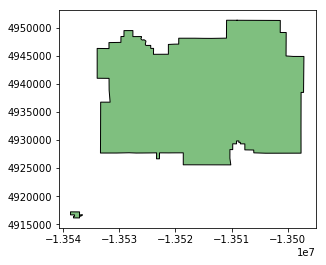

In [55]:
gdfNps.plot(color='green')